# Preprocessing

In [129]:
import pandas as pd
from scipy.io import arff

def load_arff_data(filename):
    data, _ = arff.loadarff(filename)
    df = pd.DataFrame(data)

    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                df[col] = df[col].str.decode('utf-8')
            except:
                pass

    return df

datasets = {
    'credit': load_arff_data('dataset_31_credit-g.arff'),
    'jm1': load_arff_data('jm1.arff'),
    'blood': load_arff_data('php0iVrYT.arff'),
    'bank_marketing': load_arff_data('phpkIxskf.arff'),
    'diabetes': load_arff_data('dataset_37_diabetes.arff'),
    'heart': load_arff_data('dataset_53_heart-statlog.arff'),
    'pc4': load_arff_data('pc4.arff'),
    'sonar': load_arff_data('dataset_40_sonar.arff'),
    'schizo': load_arff_data('schizo.arff'),
    'cmc': load_arff_data('cmc.arff'),
    'eucalyptus': load_arff_data('eucalyptus.arff')
}

In [130]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

processed_datasets = {}
for name, df in datasets.items():
    target_col = df.columns[-1]
    X = df.drop(columns=[target_col])
    y = df[target_col]
    y = LabelEncoder().fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    processed_datasets[name] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }

In [131]:
for name, data in processed_datasets.items():
    y_train = data['y_train']
    class_distribution = pd.Series(y_train).value_counts(normalize=True)
    print(f"Dataset: {name}")
    print("Class distribution in training set:")
    print(class_distribution)
    print("-" * 40)

Dataset: credit
Class distribution in training set:
1    0.69875
0    0.30125
Name: proportion, dtype: float64
----------------------------------------
Dataset: jm1
Class distribution in training set:
0    0.80627
1    0.19373
Name: proportion, dtype: float64
----------------------------------------
Dataset: blood
Class distribution in training set:
0    0.764214
1    0.235786
Name: proportion, dtype: float64
----------------------------------------
Dataset: bank_marketing
Class distribution in training set:
0    0.883931
1    0.116069
Name: proportion, dtype: float64
----------------------------------------
Dataset: diabetes
Class distribution in training set:
0    0.653094
1    0.346906
Name: proportion, dtype: float64
----------------------------------------
Dataset: heart
Class distribution in training set:
0    0.541667
1    0.458333
Name: proportion, dtype: float64
----------------------------------------
Dataset: pc4
Class distribution in training set:
0    0.883362
1    0.11663

In [132]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
import numpy as np

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, make_column_selector(dtype_include=np.number)),
        ('cat', categorical_transformer, make_column_selector(dtype_include=object))
    ])


In [133]:
all_results = {
    'lr': {'random_search': {}, 'bayes_opt': {}, 'default': {}},
    'decision_tree': {'random_search': {}, 'bayes_opt': {}, 'default': {}},
    'knn': {'random_search': {}, 'bayes_opt': {}, 'default': {}}
}

# Elastic net

In [134]:
from scipy.stats import loguniform, uniform

en_param_grid = {
    'classifier__C': loguniform(2**-10, 2**10),
    'classifier__l1_ratio': uniform(0, 1),
    'classifier__penalty': ['elasticnet'],
    'classifier__solver': ['saga'],
    'classifier__max_iter': [10000]
}

In [135]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

for name, data in processed_datasets.items():
    X_train = data['X_train']
    y_train = data['y_train']

    en_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression())
    ])

    en_random_search = RandomizedSearchCV(
        estimator=en_pipeline,
        param_distributions=en_param_grid,
        n_iter=100,
        scoring='roc_auc',
        cv=2,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )       

    en_random_search.fit(X_train, y_train)
    all_results['lr']['random_search'][name] = {
        'best_params': en_random_search.best_params_,
        'best_score': en_random_search.best_score_,
        'cv_results': en_random_search.cv_results_,
        'best_estimator': en_random_search.best_estimator_
    }
    

Fitting 2 folds for each of 100 candidates, totalling 200 fits
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Fitting 2 folds for each of 100 candidates, totalling 200 fits


In [136]:
from sklearn.model_selection import cross_val_score

params = all_results['lr']['random_search']['blood']['cv_results']['params']

i = 0
for p in params:
    roc_auc_scores = []
    for name, data in processed_datasets.items():
        X_train = data['X_train']
        y_train = data['y_train']

        lr_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(
                C=p['classifier__C'],
                l1_ratio=p['classifier__l1_ratio'],
                penalty='elasticnet',
                solver='saga',
                max_iter=10000
            ))
        ])

        scores = cross_val_score(lr_pipeline, X_train, y_train, cv=2, scoring='roc_auc', n_jobs=-1)
        roc_auc_scores.append(np.mean(scores))
    params[i]['mean_auc'] = np.mean(roc_auc_scores)
    params[i]['auc_values'] = roc_auc_scores
    i += 1
    

In [137]:
best_params = max(params, key=lambda x: x.get('mean_auc', float('-inf')))
i = 0
for name, data in processed_datasets.items():
    all_results['lr']['default'][name] = {
    'mean_auc': best_params['mean_auc'],
    'best_params': {k: best_params[k] for k in ['classifier__C', 'classifier__l1_ratio']},
    'auc_values': best_params['auc_values'][i]
    }
    i += 1

In [138]:
from skopt.space import Real, Categorical

lr_param_grid_bs = {
    'classifier__C': Real(2**-10, 2**10, prior='log-uniform'),
    'classifier__l1_ratio': Real(0, 1),
    'classifier__penalty': Categorical(['elasticnet']),
    'classifier__solver': Categorical(['saga']),
    'classifier__max_iter': Categorical([10000])
}

In [139]:
from skopt import BayesSearchCV

for name, data in processed_datasets.items():
    X_train = data['X_train']
    y_train = data['y_train']

    lr_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression())
    ])

    lr_bayes_search = BayesSearchCV(
        estimator=lr_pipeline,
        search_spaces=lr_param_grid_bs,
        n_iter=100,
        scoring='roc_auc',
        cv=2,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )       

    lr_bayes_search.fit(X_train, y_train)
    all_results['lr']['bayes_opt'][name] = {
        'best_params': lr_bayes_search.best_params_,
        'best_score': lr_bayes_search.best_score_,
        'cv_results': lr_bayes_search.cv_results_,
        'best_estimator': lr_bayes_search.best_estimator_
    }

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fi

In [140]:
for name, data in processed_datasets.items():
    print(f"Dataset: {name}")
    print(f"Default params AUC: {all_results['lr']['default'][name]['auc_values']:.5f}")
    print(f"Random Search AUC: {all_results['lr']['random_search'][name]['best_score']:.5f}")
    print(f"Random Search difference: {all_results['lr']['random_search'][name]['best_score'] - all_results['lr']['default'][name]['auc_values']:.5f}")
    print(f"Bayesian Opt AUC: {all_results['lr']['bayes_opt'][name]['best_score']:.5f}")
    print(f"Bayesian Opt difference: {all_results['lr']['bayes_opt'][name]['best_score'] - all_results['lr']['default'][name]['auc_values']:.5f}")
    
    

Dataset: credit
Default params AUC: 0.75980
Random Search AUC: 0.76026
Random Search difference: 0.00046
Bayesian Opt AUC: 0.76055
Bayesian Opt difference: 0.00075
Dataset: jm1
Default params AUC: 0.70942
Random Search AUC: 0.71324
Random Search difference: 0.00382
Bayesian Opt AUC: 0.71324
Bayesian Opt difference: 0.00382
Dataset: blood
Default params AUC: 0.75261
Random Search AUC: 0.75261
Random Search difference: 0.00000
Bayesian Opt AUC: 0.75314
Bayesian Opt difference: 0.00053
Dataset: bank_marketing
Default params AUC: 0.90701
Random Search AUC: 0.90741
Random Search difference: 0.00040
Bayesian Opt AUC: 0.90743
Bayesian Opt difference: 0.00042
Dataset: diabetes
Default params AUC: 0.82689
Random Search AUC: 0.83126
Random Search difference: 0.00437
Bayesian Opt AUC: 0.83147
Bayesian Opt difference: 0.00458
Dataset: heart
Default params AUC: 0.89914
Random Search AUC: 0.90190
Random Search difference: 0.00276
Bayesian Opt AUC: 0.90415
Bayesian Opt difference: 0.00500
Dataset: pc

# Decision tree

In [141]:
from scipy.stats import randint 

dt_param_grid = {
    'classifier__max_depth': randint(1, 31),
    'classifier__min_samples_split': randint(2, 61),
    'classifier__min_samples_leaf': randint(2, 61),
}


In [142]:
from sklearn.tree import DecisionTreeClassifier

for name, data in processed_datasets.items():
    X_train = data['X_train']
    y_train = data['y_train']

    dt_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier())
    ])

    dt_random_search = RandomizedSearchCV(
        estimator=dt_pipeline,
        param_distributions=dt_param_grid,
        n_iter=100,
        scoring='roc_auc',
        cv=2,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )       

    dt_random_search.fit(X_train, y_train)
    all_results['decision_tree']['random_search'][name] = {
        'best_params': dt_random_search.best_params_,
        'best_score': dt_random_search.best_score_,
        'cv_results': dt_random_search.cv_results_,
        'best_estimator': dt_random_search.best_estimator_
    }

Fitting 2 folds for each of 100 candidates, totalling 200 fits
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Fitting 2 folds for each of 100 candidates, totalling 200 fits


In [143]:
from sklearn.model_selection import cross_val_score

params = all_results['decision_tree']['random_search']['blood']['cv_results']['params']

i = 0
for p in params:
    roc_auc_scores = []
    for name, data in processed_datasets.items():
        X_train = data['X_train']
        y_train = data['y_train']

        svm_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', DecisionTreeClassifier(
                max_depth=p['classifier__max_depth'],
                min_samples_split=p['classifier__min_samples_split'],
                min_samples_leaf=p['classifier__min_samples_leaf']))
        ])

        scores = cross_val_score(svm_pipeline, X_train, y_train, cv=2, scoring='roc_auc', n_jobs=-1)
        roc_auc_scores.append(np.mean(scores))
    params[i]['mean_auc'] = np.mean(roc_auc_scores)
    params[i]['auc_values'] = roc_auc_scores
    i += 1
    

In [144]:
best_params = max(params, key=lambda x: x.get('mean_auc', float('-inf')))
i = 0
for name, data in processed_datasets.items():
    all_results['decision_tree']['default'][name] = {
    'mean_auc': best_params['mean_auc'],
    'best_params': {k: best_params[k] for k in ['classifier__max_depth', 'classifier__min_samples_split', 'classifier__min_samples_leaf']},
    'auc_values': best_params['auc_values'][i]
    }
    i += 1

In [145]:
from skopt.space import Integer

dt_param_grid_bs = {
    'classifier__max_depth': Integer(1, 30),
    'classifier__min_samples_split': Integer(2, 60),
    'classifier__min_samples_leaf': Integer(2, 60),
}

In [146]:
from skopt import BayesSearchCV

for name, data in processed_datasets.items():
    X_train = data['X_train']
    y_train = data['y_train']

    dt_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier())
    ])

    dt_bayes_search = BayesSearchCV(
        estimator=dt_pipeline,
        search_spaces=dt_param_grid_bs,
        n_iter=100,
        scoring='roc_auc',
        cv=2,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )       

    dt_bayes_search.fit(X_train, y_train)
    all_results['decision_tree']['bayes_opt'][name] = {
        'best_params': dt_bayes_search.best_params_,
        'best_score': dt_bayes_search.best_score_,
        'cv_results': dt_bayes_search.cv_results_,
        'best_estimator': dt_bayes_search.best_estimator_
    }

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fi

/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [13, 29, 60] before, using random point [25, 27, 16]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [13, 29, 60] before, using random point [3, 35, 37]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [13, 29, 60] before, using random point [1, 19, 47]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fi

/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 21, 2] before, using random point [29, 46, 33]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fi

/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 23, 2] before, using random point [28, 30, 55]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fi

/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [27, 41, 33]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [23, 4, 9]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [16, 16, 35]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [5, 11, 55]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [23, 25, 9]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [14, 23, 26]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [11, 3, 47]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [26, 53, 59]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [23, 33, 25]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [4, 54, 51]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [18, 17, 30]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [11, 54, 38]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [22, 21, 25]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [15, 25, 49]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [17, 58, 50]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [27, 31, 33]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [13, 46, 19]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [18, 38, 9]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [6, 16, 17]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [14, 51, 21]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [5, 60, 50]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [4, 54, 29]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [9, 7, 46]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [18, 34, 28]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [9, 40, 34]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [13, 37, 15]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [13, 58, 21]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [13, 47, 49]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [4, 11, 12]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [20, 47, 54]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [20, 33, 3]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 8, 2] before, using random point [21, 10, 20]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [21, 9, 2] before, using random point [10, 56, 31]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [21, 9, 2] before, using random point [24, 29, 24]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [21, 9, 2] before, using random point [10, 20, 57]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [21, 9, 2] before, using random point [30, 30, 46]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [21, 9, 2] before, using random point [8, 52, 17]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [21, 9, 2] before, using random point [16, 18, 53]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [21, 9, 2] before, using random point [14, 36, 19]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [21, 9, 2] before, using random point [24, 6, 27]
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fi

In [147]:
for name, data in processed_datasets.items():
    print(f"Dataset: {name}")
    print(f"Default params AUC: {all_results['decision_tree']['default'][name]['auc_values']:.5f}")
    print(f"Random Search AUC: {all_results['decision_tree']['random_search'][name]['best_score']:.5f}")
    print(f"Random Search difference: {all_results['decision_tree']['random_search'][name]['best_score'] - all_results['decision_tree']['default'][name]['auc_values']:.5f}")
    print(f"Bayesian Opt AUC: {all_results['decision_tree']['bayes_opt'][name]['best_score']:.5f}")
    print(f"Bayesian Opt difference: {all_results['decision_tree']['bayes_opt'][name]['best_score'] - all_results['decision_tree']['default'][name]['auc_values']:.5f}")
    
    

Dataset: credit
Default params AUC: 0.67023
Random Search AUC: 0.68780
Random Search difference: 0.01756
Bayesian Opt AUC: 0.68789
Bayesian Opt difference: 0.01766
Dataset: jm1
Default params AUC: 0.67792
Random Search AUC: 0.70992
Random Search difference: 0.03200
Bayesian Opt AUC: 0.71020
Bayesian Opt difference: 0.03229
Dataset: blood
Default params AUC: 0.70052
Random Search AUC: 0.74765
Random Search difference: 0.04713
Bayesian Opt AUC: 0.74765
Bayesian Opt difference: 0.04713
Dataset: bank_marketing
Default params AUC: 0.86059
Random Search AUC: 0.90073
Random Search difference: 0.04014
Bayesian Opt AUC: 0.90100
Bayesian Opt difference: 0.04040
Dataset: diabetes
Default params AUC: 0.76001
Random Search AUC: 0.80932
Random Search difference: 0.04931
Bayesian Opt AUC: 0.80932
Bayesian Opt difference: 0.04931
Dataset: heart
Default params AUC: 0.77616
Random Search AUC: 0.84154
Random Search difference: 0.06538
Bayesian Opt AUC: 0.81869
Bayesian Opt difference: 0.04253
Dataset: pc

# KNN


In [148]:
knn_param_grid = {
    'classifier__n_neighbors': randint(1, 31),
    'classifier__weights': ['uniform', 'distance'],
}

In [149]:
from sklearn.neighbors import KNeighborsClassifier

for name, data in processed_datasets.items():
    X_train = data['X_train']
    y_train = data['y_train']

    knn_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ])

    knn_random_search = RandomizedSearchCV(
        estimator=knn_pipeline,
        param_distributions=knn_param_grid,
        n_iter=50,
        scoring='roc_auc',
        cv=2,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )       

    knn_random_search.fit(X_train, y_train)
    all_results['knn']['random_search'][name] = {
        'best_params': knn_random_search.best_params_,
        'best_score': knn_random_search.best_score_,
        'cv_results': knn_random_search.cv_results_,
        'best_estimator': knn_random_search.best_estimator_
    }

Fitting 2 folds for each of 50 candidates, totalling 100 fits
Fitting 2 folds for each of 50 candidates, totalling 100 fits
Fitting 2 folds for each of 50 candidates, totalling 100 fits
Fitting 2 folds for each of 50 candidates, totalling 100 fits
Fitting 2 folds for each of 50 candidates, totalling 100 fits
Fitting 2 folds for each of 50 candidates, totalling 100 fits
Fitting 2 folds for each of 50 candidates, totalling 100 fits
Fitting 2 folds for each of 50 candidates, totalling 100 fits
Fitting 2 folds for each of 50 candidates, totalling 100 fits
Fitting 2 folds for each of 50 candidates, totalling 100 fits
Fitting 2 folds for each of 50 candidates, totalling 100 fits


In [150]:
from sklearn.model_selection import cross_val_score

params = all_results['knn']['random_search']['blood']['cv_results']['params']

i = 0
for p in params:
    roc_auc_scores = []
    for name, data in processed_datasets.items():
        X_train = data['X_train']
        y_train = data['y_train']

        knn_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', KNeighborsClassifier(
                n_neighbors=p['classifier__n_neighbors'],
                weights=p['classifier__weights']))
        ])

        scores = cross_val_score(knn_pipeline, X_train, y_train, cv=2, scoring='roc_auc', n_jobs=-1)
        roc_auc_scores.append(np.mean(scores))
    params[i]['mean_auc'] = np.mean(roc_auc_scores)
    params[i]['auc_values'] = roc_auc_scores
    i += 1
    

In [151]:
best_params = max(params, key=lambda x: x.get('mean_auc', float('-inf')))
i = 0
for name, data in processed_datasets.items():
    all_results['knn']['default'][name] = {
    'mean_auc': best_params['mean_auc'],
    'best_params': {k: best_params[k] for k in ['classifier__n_neighbors', 'classifier__weights']},
    'auc_values': best_params['auc_values'][i]
    }
    i += 1

In [152]:
knn_param_grid_bs = {
    'classifier__n_neighbors': Integer(1, 30),
    'classifier__weights': Categorical(['uniform', 'distance'])
}

In [153]:
from skopt import BayesSearchCV

for name, data in processed_datasets.items():
    X_train = data['X_train']
    y_train = data['y_train']

    knn_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ])

    knn_bayes_search = BayesSearchCV(
        estimator=knn_pipeline,
        search_spaces=knn_param_grid_bs,
        n_iter=50,
        scoring='roc_auc',
        cv=2,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )       

    knn_bayes_search.fit(X_train, y_train)
    all_results['knn']['bayes_opt'][name] = {
        'best_params': knn_bayes_search.best_params_,
        'best_score': knn_bayes_search.best_score_,
        'cv_results': knn_bayes_search.cv_results_,
        'best_estimator': knn_bayes_search.best_estimator_
    }

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fi

/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [14, 'distance'] before, using random point [7, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [14, 'distance'] before, using random point [5, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [15, 'distance'] before, using random point [7, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [15, 'distance'] before, using random point [15, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [15, 'distance'] before, using random point [22, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [15, 'distance'] before, using random point [20, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [15, 'distance'] before, using random point [6, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [15, 'distance'] before, using random point [5, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5, 'distance'] before, using random point [25, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [15, 'distance'] before, using random point [21, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'uniform'] before, using random point [20, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fi

/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [24, 'uniform'] before, using random point [12, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'distance'] before, using random point [19, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'distance'] before, using random point [7, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'distance'] before, using random point [12, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10, 'distance'] before, using random point [16, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [19, 'uniform'] before, using random point [23, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [27, 'distance'] before, using random point [21, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'distance'] before, using random point [30, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 'uniform'] before, using random point [17, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [29, 'distance'] before, using random point [5, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [25, 'uniform'] before, using random point [19, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'distance'] before, using random point [8, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10, 'distance'] before, using random point [6, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'distance'] before, using random point [5, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5, 'distance'] before, using random point [25, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'distance'] before, using random point [21, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'uniform'] before, using random point [20, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fi

/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [14, 'uniform'] before, using random point [2, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [19, 'uniform'] before, using random point [14, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fi

/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [8, 'uniform'] before, using random point [18, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'distance'] before, using random point [17, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'distance'] before, using random point [29, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'distance'] before, using random point [5, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'distance'] before, using random point [7, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'distance'] before, using random point [22, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [25, 'uniform'] before, using random point [22, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'distance'] before, using random point [25, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'distance'] before, using random point [19, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'distance'] before, using random point [26, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [17, 'uniform'] before, using random point [25, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fi

/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [21, 'distance'] before, using random point [5, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'distance'] before, using random point [7, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'distance'] before, using random point [15, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [21, 'distance'] before, using random point [22, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [26, 'distance'] before, using random point [21, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'uniform'] before, using random point [20, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fi

/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [21, 'distance'] before, using random point [5, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fi

/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'distance'] before, using random point [10, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'distance'] before, using random point [24, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'distance'] before, using random point [12, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'distance'] before, using random point [2, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [26, 'distance'] before, using random point [14, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [26, 'distance'] before, using random point [5, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'distance'] before, using random point [30, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'distance'] before, using random point [21, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'uniform'] before, using random point [20, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [11, 'distance'] before, using random point [25, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [7, 'distance'] before, using random point [12, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [7, 'distance'] before, using random point [5, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fi

/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [4, 'distance'] before, using random point [26, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [4, 'distance'] before, using random point [29, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [4, 'distance'] before, using random point [4, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 'distance'] before, using random point [3, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 'distance'] before, using random point [25, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fi

/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 'distance'] before, using random point [19, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fi

/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [28, 'uniform'] before, using random point [7, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [28, 'uniform'] before, using random point [14, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fi

/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'distance'] before, using random point [10, 'uniform']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/k1eca/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'distance'] before, using random point [25, 'distance']
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fi

In [154]:
for name, data in processed_datasets.items():
    print(f"Dataset: {name}")
    print(f"Default params AUC: {all_results['knn']['default'][name]['auc_values']:.5f}")
    print(f"Random Search AUC: {all_results['knn']['random_search'][name]['best_score']:.5f}")
    print(f"Random Search difference: {all_results['knn']['random_search'][name]['best_score'] - all_results['knn']['default'][name]['auc_values']:.5f}")
    print(f"Bayesian Opt AUC: {all_results['knn']['bayes_opt'][name]['best_score']:.5f}")
    print(f"Bayesian Opt difference: {all_results['knn']['bayes_opt'][name]['best_score'] - all_results['knn']['default'][name]['auc_values']:.5f}")
    
    

Dataset: credit
Default params AUC: 0.71643
Random Search AUC: 0.71785
Random Search difference: 0.00142
Bayesian Opt AUC: 0.71785
Bayesian Opt difference: 0.00142
Dataset: jm1
Default params AUC: 0.73642
Random Search AUC: 0.73912
Random Search difference: 0.00271
Bayesian Opt AUC: 0.73912
Bayesian Opt difference: 0.00271
Dataset: blood
Default params AUC: 0.71123
Random Search AUC: 0.74374
Random Search difference: 0.03251
Bayesian Opt AUC: 0.74383
Bayesian Opt difference: 0.03260
Dataset: bank_marketing
Default params AUC: 0.89026
Random Search AUC: 0.89664
Random Search difference: 0.00637
Bayesian Opt AUC: 0.89664
Bayesian Opt difference: 0.00637
Dataset: diabetes
Default params AUC: 0.80985
Random Search AUC: 0.81298
Random Search difference: 0.00313
Bayesian Opt AUC: 0.81298
Bayesian Opt difference: 0.00313
Dataset: heart
Default params AUC: 0.90586
Random Search AUC: 0.90915
Random Search difference: 0.00328
Bayesian Opt AUC: 0.91052
Bayesian Opt difference: 0.00466
Dataset: pc

In [155]:
for dataset_idx, dataset_name in enumerate(processed_datasets.keys()):
    for model_idx, model_name in enumerate(['lr', 'decision_tree', 'knn']):
        all_results[model_name]['random_search'][dataset_name]['tunability'] = all_results[model_name]['random_search'][dataset_name]['best_score'] - all_results[model_name]['default'][dataset_name]['auc_values']
        all_results[model_name]['bayes_opt'][dataset_name]['tunability'] = all_results[model_name]['bayes_opt'][dataset_name]['best_score'] - all_results[model_name]['default'][dataset_name]['auc_values']

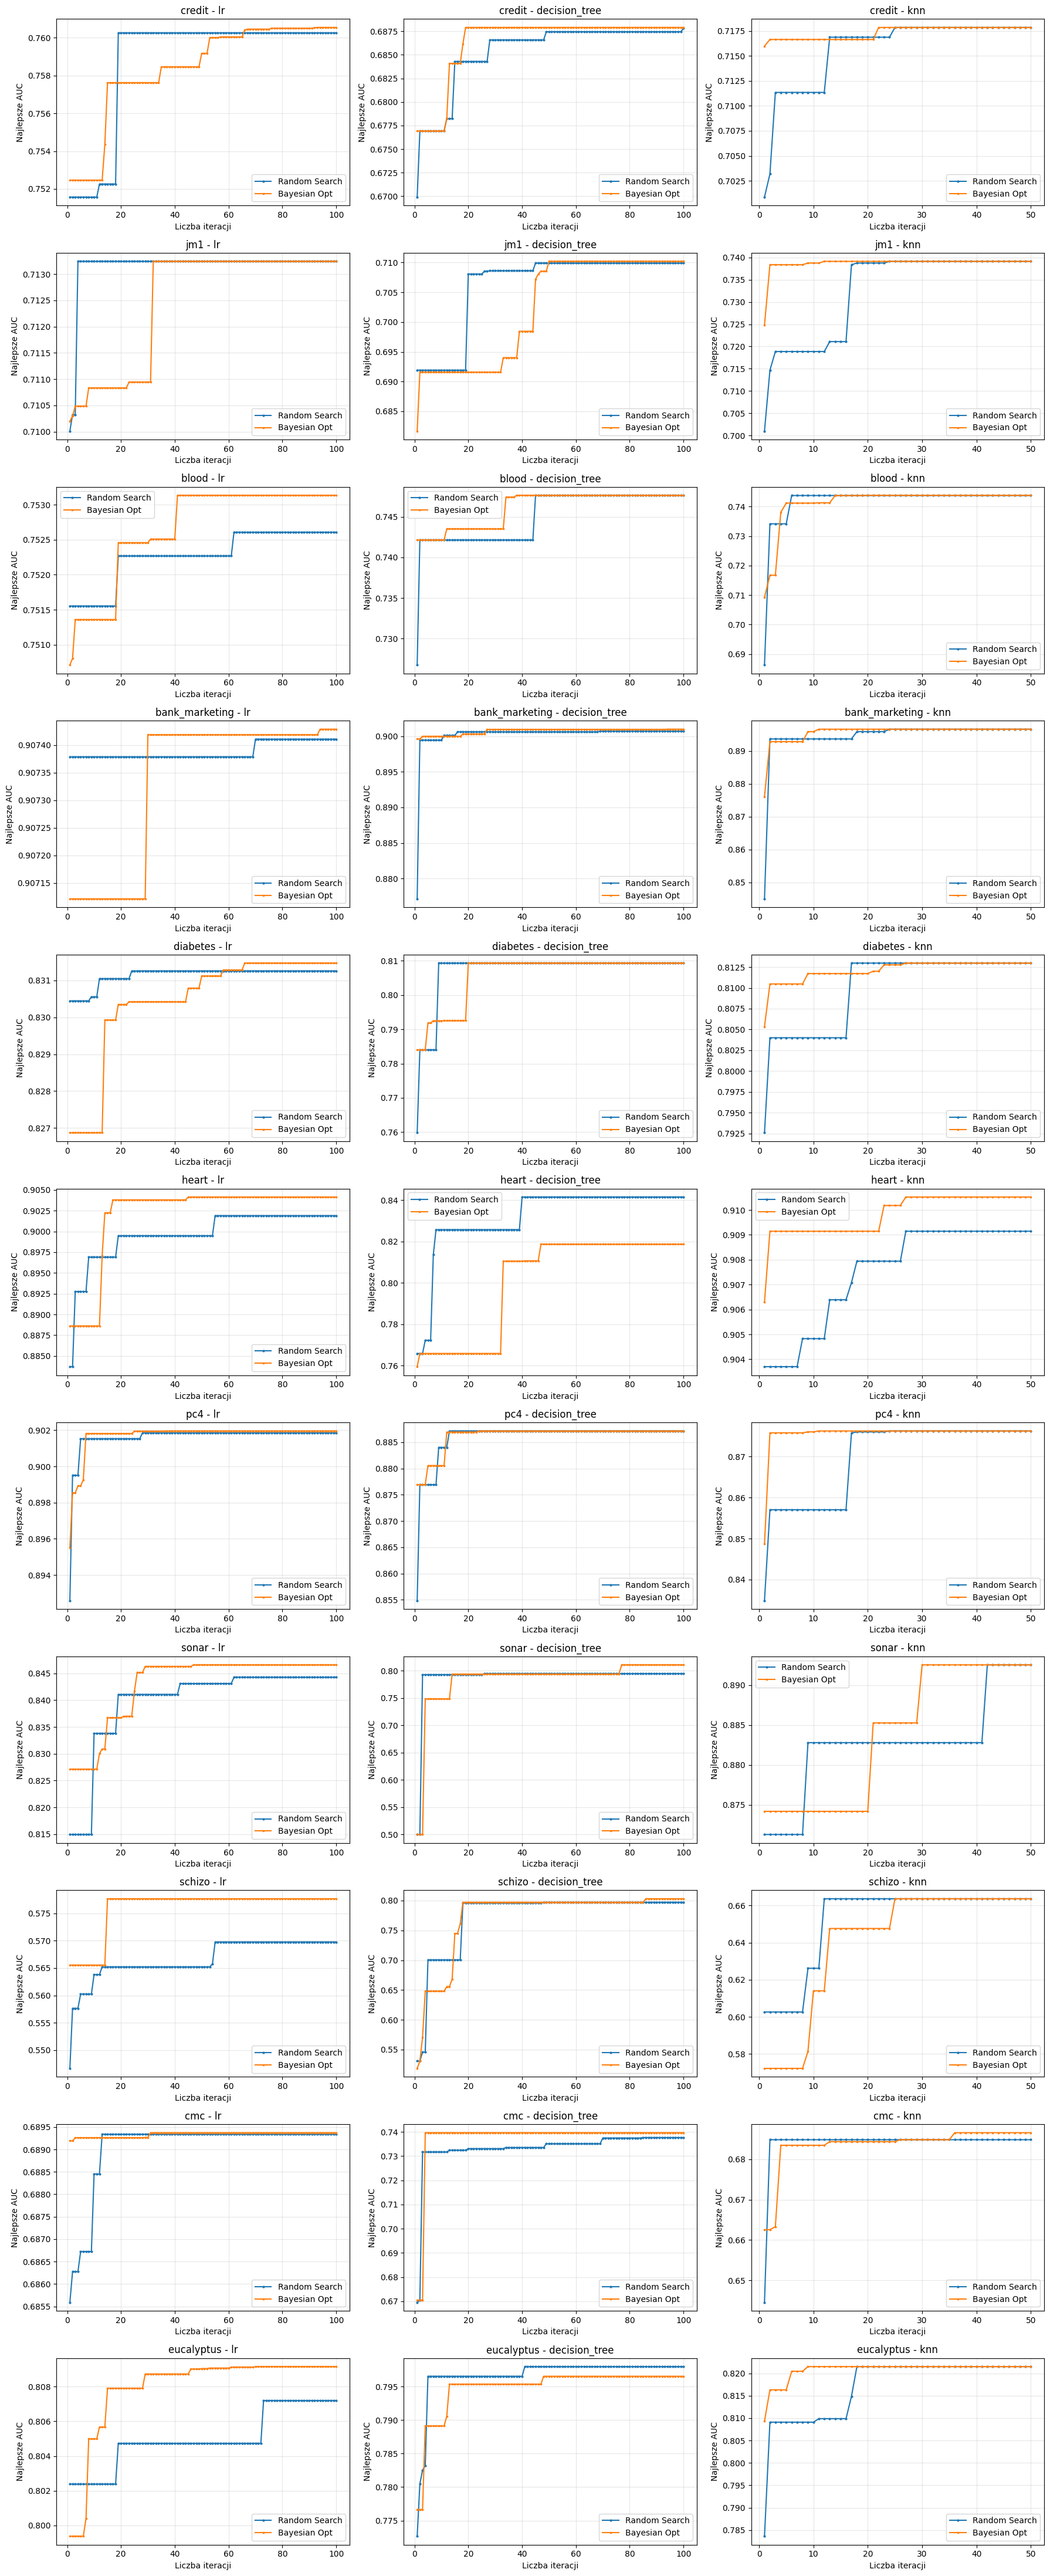

In [161]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(processed_datasets), 3, figsize=(18, 4*len(processed_datasets)))
if len(processed_datasets) == 1:
    axes = [axes]

for dataset_idx, dataset_name in enumerate(processed_datasets.keys()):
    for model_idx, model_name in enumerate(['lr', 'decision_tree', 'knn']):
        ax = axes[dataset_idx][model_idx]
        
        # Random Search convergence
        rs_results = all_results[model_name]['random_search'][dataset_name]['cv_results']
        rs_scores = rs_results['mean_test_score']
        rs_cummax = np.maximum.accumulate(rs_scores)
        
        bs_results = all_results[model_name]['bayes_opt'][dataset_name]['cv_results']
        bs_scores = bs_results['mean_test_score']
        bs_cummax = np.maximum.accumulate(bs_scores)
        
        # Wykres
        ax.plot(range(1, len(rs_cummax)+1), rs_cummax, label='Random Search', marker='o', markersize=2)
        ax.plot(range(1, len(bs_cummax)+1), bs_cummax, label='Bayesian Opt', marker='s', markersize=2)

        ax.set_xlabel('Liczba iteracji')
        ax.set_ylabel('Najlepsze AUC')
        ax.set_title(f'{dataset_name} - {model_name}')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [185]:
stable_steps = {}

TARGET_RATIO = 0.999  # 99% najlepszego wyniku

for model_name in ['lr', 'decision_tree', 'knn']:
    stable_steps[model_name] = {'random_search': 0,
                                'bayes_opt': 0}

    for dataset_name in processed_datasets.keys():

        ### ------------------- RANDOM SEARCH -------------------
        rs_results = all_results[model_name]['random_search'][dataset_name]['cv_results']
        rs_scores = np.array(rs_results['mean_test_score'])

        rs_cummax = np.maximum.accumulate(rs_scores)
        rs_best = rs_cummax[-1]
        rs_threshold = rs_best * TARGET_RATIO

        stable_step_rs = next((i+1 for i, s in enumerate(rs_cummax)
                               if s >= rs_threshold),
                              len(rs_cummax))
        stable_steps[model_name]['random_search'] += stable_step_rs


        ### ------------------- BAYES OPT -------------------
        bs_results = all_results[model_name]['bayes_opt'][dataset_name]['cv_results']

        # sortowanie iteracji, jeśli dostępne
        if 'iteration' in bs_results:
            order = np.argsort(bs_results['iteration'])
        elif 'counter' in bs_results:
            order = np.argsort(bs_results['counter'])
        else:
            order = np.arange(len(bs_results['mean_test_score']))

        bs_scores = np.array(bs_results['mean_test_score'])[order]
        bs_cummax = np.maximum.accumulate(bs_scores)
        bs_best = bs_cummax[-1]
        bs_threshold = bs_best * TARGET_RATIO

        stable_step_bs = next((i+1 for i, s in enumerate(bs_cummax)
                               if s >= bs_threshold),
                              len(bs_cummax))
        stable_steps[model_name]['bayes_opt'] += stable_step_bs


    # średnia po datasetach
    stable_steps[model_name]['random_search'] /= len(processed_datasets)
    stable_steps[model_name]['bayes_opt'] /= len(processed_datasets)

mean_all_models = {
    'random_search': 27.45,
    'bayes_opt': 26.21
}



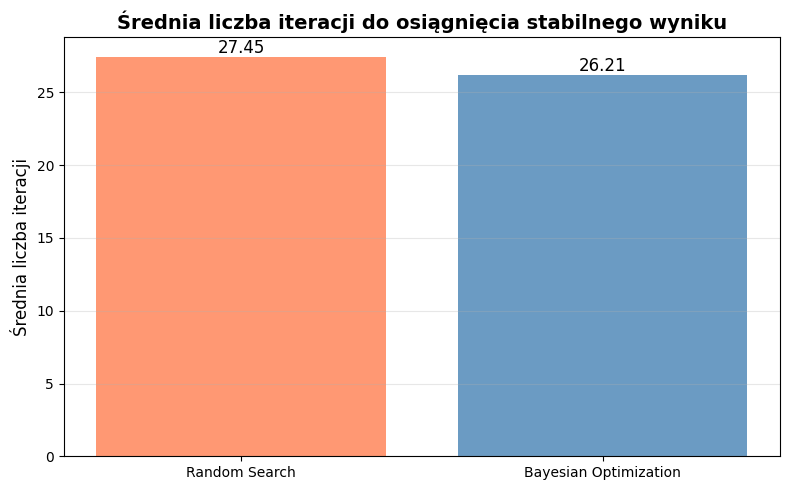

In [209]:
import matplotlib.pyplot as plt

# Dane do wykresu
methods = ['Random Search', 'Bayesian Optimization']
means = [mean_all_models['random_search'], mean_all_models['bayes_opt']]
colors = ['#FF7F50', '#4682B4']

# Tworzymy wykres słupkowy
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(methods, means, color=colors, alpha=0.8)

# Dodajemy wartości nad słupkami
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.0, f'{height:.2f}', 
            ha='center', va='bottom', fontsize=12)

# Opisy osi i tytuł
ax.set_ylabel('Średnia liczba iteracji', fontsize=12)
ax.set_title('Średnia liczba iteracji do osiągnięcia stabilnego wyniku', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


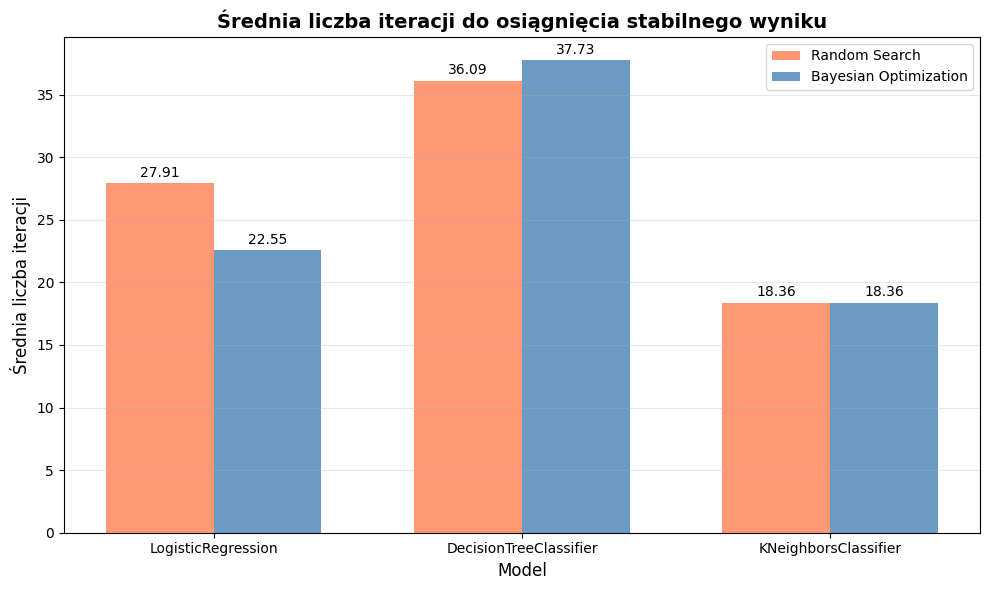

In [207]:
models = list(stable_steps.keys())
methods = ['random_search', 'bayes_opt']
method_labels = ['Random Search', 'Bayesian Optimization']
model_labels = ['LogisticRegression', 'DecisionTreeClassifier', 'KNeighborsClassifier']

colors = ['#FF7F50', '#4682B4']
# Przygotowanie danych do wykresu
rs_values = [stable_steps[m]['random_search'] for m in models]
bo_values = [stable_steps[m]['bayes_opt'] for m in models]

x = np.arange(len(models))  # pozycje modeli na osi X
width = 0.35  # szerokość słupków

fig, ax = plt.subplots(figsize=(10, 6))

# Słupki dla Random Search i Bayesian Optimization
bars1 = ax.bar(x - width/2, rs_values, width, label='Random Search', color=colors[0], alpha=0.8)
bars2 = ax.bar(x + width/2, bo_values, width, label='Bayesian Optimization', color=colors[1], alpha=0.8)

# Dodanie wartości nad słupkami
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.3, f'{height:.2f}',
                ha='center', va='bottom', fontsize=10)

# Opisy osi i tytuł
ax.set_ylabel('Średnia liczba iteracji', fontsize=12)
ax.set_xlabel('Model', fontsize=12)
ax.set_title('Średnia liczba iteracji do osiągnięcia stabilnego wyniku', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_labels)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

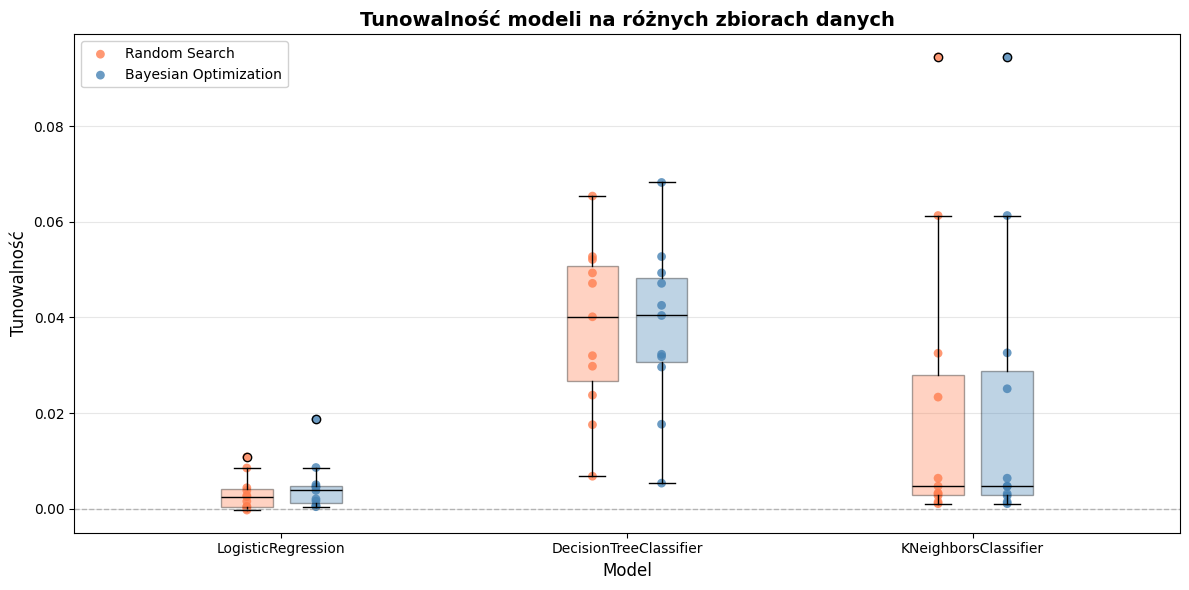

In [212]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

datasets = ['credit', 'jm1', 'blood', 'bank_marketing', 'diabetes', 'heart', 'pc4', 'sonar', 'schizo', 'cmc', 'eucalyptus']
models_names = ['LogisticRegression', 'DecisionTreeClassifier', 'KNeighborsClassifier']
model_keys = ['lr', 'decision_tree', 'knn']

data_for_plot = []

for model_name, model_key in zip(models_names, model_keys):
    for dataset in datasets:
        default_auc = all_results[model_key]['default'][dataset]['auc_values']
        random_auc = all_results[model_key]['random_search'][dataset]['best_score']
        bayes_auc = all_results[model_key]['bayes_opt'][dataset]['best_score']

        data_for_plot.append({
            'Model': model_name,
            'Dataset': dataset,
            'Method': 'Random Search',
            'Difference': random_auc - default_auc
        })
        data_for_plot.append({
            'Model': model_name,
            'Dataset': dataset,
            'Method': 'Bayesian Optimization',
            'Difference': bayes_auc - default_auc
        })

df = pd.DataFrame(data_for_plot)

fig, ax = plt.subplots(figsize=(12, 6))

colors = {'Random Search': '#FF7F50', 'Bayesian Optimization': '#4682B4'}
markers = {'Random Search': 'o', 'Bayesian Optimization': 'o'}

models = df['Model'].unique()
x_positions = {model: i for i, model in enumerate(models)}

# --- Scatter + Boxplots ---
for method, offset in [('Random Search', -0.1), ('Bayesian Optimization', 0.1)]:
    method_data = df[df["Method"] == method]

    x_coords = [x_positions[m] + offset for m in method_data['Model']]
    y_coords = method_data["Difference"].values

    ax.scatter(
        x_coords, y_coords,
        c=colors[method],
        marker=markers[method],
        s=40,
        alpha=0.8,
        edgecolors='none',
        label=method   # FIX HERE
    )

    for model in models:
        grp = df[(df["Model"] == model) & (df["Method"] == method)]
        y_vals = grp["Difference"].values

        if len(y_vals) > 0:
            ax.boxplot(
                y_vals,
                positions=[x_positions[model] + offset],
                widths=0.15,
                patch_artist=True,
                boxprops=dict(facecolor=colors[method], alpha=0.35),
                medianprops=dict(color="black")
            )



# Zero line
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

ax.set_xticks(list(x_positions.values()))
ax.set_xticklabels(list(x_positions.keys()))

ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("Tunowalność", fontsize=12)
ax.set_title("Tunowalność modeli na różnych zbiorach danych",
             fontsize=14, fontweight="bold")

ax.legend(loc='upper left', framealpha=0.9)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [175]:
mean_tunability = {}
for model_name, model_key in zip(models_names, model_keys):
    tunability_values = []
    for dataset in datasets:
        tunability_values.append(all_results[model_key]['random_search'][dataset]['tunability'])
        tunability_values.append(all_results[model_key]['bayes_opt'][dataset]['tunability'])
    mean_tunability[model_name] = np.mean(tunability_values)
mean_tunability

{'Logistic Regression': 0.003882643945960193,
 'Decision Tree': 0.037897654464716705,
 'KNN': 0.021446170597701476}

In [176]:
mean_tunability_random_search = {}
for model_name, model_key in zip(models_names, model_keys):
    tunability_values = []
    for dataset in datasets:
        tunability = all_results[model_key]['random_search'][dataset]['tunability']
        tunability_values.append(tunability)
    mean_tunability_random_search[model_name] = np.mean(tunability_values)
mean_tunability_random_search

{'Logistic Regression': 0.0031737190097959962,
 'Decision Tree': 0.03788120334807757,
 'KNN': 0.021300672113994615}

In [177]:
mean_tunability_bayes_opt = {}
for model_name, model_key in zip(models_names, model_keys):
    tunability_values = []
    for dataset in datasets:
        tunability = all_results[model_key]['bayes_opt'][dataset]['tunability']
        tunability_values.append(tunability)
    mean_tunability_bayes_opt[model_name] = np.mean(tunability_values)
mean_tunability_bayes_opt

{'Logistic Regression': 0.004591568882124389,
 'Decision Tree': 0.037914105581355835,
 'KNN': 0.021591669081408336}

In [ ]:
mean_step_better_than_default = {}
for model_name, model_key in zip(models_names, model_keys):
    mean_step_values = []
    for dataset in ['blood', 'credit', 'diabetes', 'heart', 'bank_marketing']:
        rs_cv_results = all_results[model_key]['random_search'][dataset]['cv_results']
        bs_cv_results = all_results[model_key]['bayes_opt'][dataset]['cv_results']
        default_auc = all_results[model_key]['default'][dataset]['auc_values']

        # Random Search
        rs_better_steps = np.sum(rs_cv_results['mean_test_score'] > default_auc)
        rs_mean_step = rs_better_steps / len(rs_cv_results['mean_test_score'])
        mean_step_values.append(rs_mean_step)

        # Bayesian Optimization
        bs_better_steps = np.sum(bs_cv_results['mean_test_score'] > default_auc)
        bs_mean_step = bs_better_steps / len(bs_cv_results['mean_test_score'])
        mean_step_values.append(bs_mean_step)

    mean_step_better_than_default[model_name] = np.mean(mean_step_values)
mean_step_better_than_default

{'Logistic Regression': 0.14900000000000002,
 'Decision Tree': 0.251,
 'KNN': 0.184}

KeyError: 'LogisticRegression'

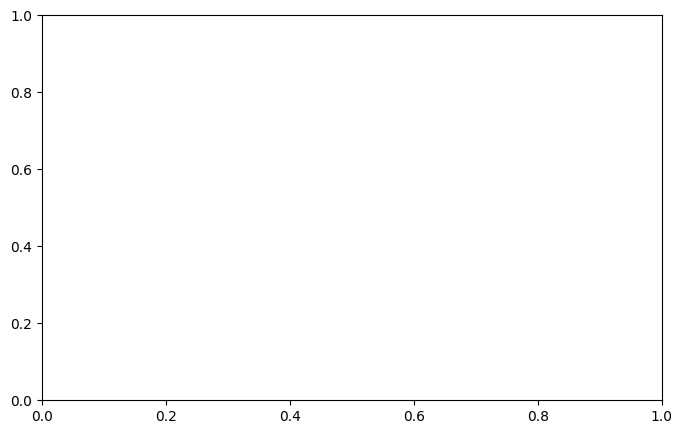

In [213]:
x = np.arange(len(models_names))
width = 0.25

# Create bar plot
fig, ax = plt.subplots(figsize=(8, 5))
bar1 = ax.bar(x - width, [mean_tunability_random_search[m] for m in models_names], width, label='Random Search')
bar2 = ax.bar(x, [mean_tunability_bayes_opt[m] for m in models_names], width, label='Bayes Opt')
bar3 = ax.bar(x + width, [mean_tunability[m] for m in models_names], width, label='Overall Mean')

ax.set_ylabel('Średnia tunowalność')
ax.set_title('Średnia tunowalność modeli z podziałem na metodę optymalizacji')
ax.set_xticks(x)
ax.set_xticklabels(models_names)
ax.legend()
plt.tight_layout()
plt.show()

In [211]:
import pandas as pd

# Prepare data for the table
data = []
for model_name, model_results in all_results.items():
    for search_method in ['random_search', 'bayes_opt']:
        for dataset_name, dataset_results in model_results[search_method].items():
            tunability = dataset_results.get('tunability', None)
            data.append({
                'Model': model_name,
                'Dataset': dataset_name,
                'Search Method': search_method,
                'Tunability': tunability
            })

# Create a DataFrame
tunability_table = pd.DataFrame(data)

# Display the table
tunability_table

,Model,Dataset,Search Method,Tunability
0,lr,credit,random_search,0.000463
1,lr,jm1,random_search,0.003819
2,lr,blood,random_search,0.000000
3,lr,bank_marketing,random_search,0.000399
4,lr,diabetes,random_search,0.004369
...,...,...,...,...
61,knn,pc4,bayes_opt,0.004712
62,knn,sonar,bayes_opt,0.061312
63,knn,schizo,bayes_opt,0.094473
64,knn,cmc,bayes_opt,0.025079


In [220]:
print(all_results['lr']['default']['blood']['best_params'],
all_results['decision_tree']['default']['blood']['best_params'],
all_results['knn']['default']['blood']['best_params'])


{'classifier__C': 0.080217982872686, 'classifier__l1_ratio': 0.11005192452767676} {'classifier__max_depth': 7, 'classifier__min_samples_split': 9, 'classifier__min_samples_leaf': 10} {'classifier__n_neighbors': 22, 'classifier__weights': 'distance'}
